<a href="https://www.kaggle.com/code/zaki171/horse-racing-data-analysis?scriptVersionId=106139359" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/big-data-derby-2022/nyra_tracking_table.csv
/kaggle/input/big-data-derby-2022/nyra_start_table.csv
/kaggle/input/big-data-derby-2022/nyra_race_table.csv
/kaggle/input/big-data-derby-2022/nyra_2019_complete.csv


In [2]:
horse_data = pd.read_csv('/kaggle/input/big-data-derby-2022/nyra_start_table.csv',names = ['track_id', 'race_date', 'race_number', 'program_number', 'weight_carried', 'jockey', 'odds', 'position_at_finish'])
track_data = pd.read_csv('/kaggle/input/big-data-derby-2022/nyra_race_table.csv')
tracking_data = pd.read_csv('/kaggle/input/big-data-derby-2022/nyra_tracking_table.csv', names = ['track_id', 'race_date', 'race_number', 'program_number', 'trakus_index', 'latitude', 'longitude'])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (2,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# **START TABLE**

In [3]:
horse_data.head()

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3
2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4
3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5
4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1


In [4]:
horse_data['odds'] = horse_data['odds']/100
horse_data

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish
0,AQU,2019-01-01,1,1,123,Dylan Davis,1.30,2
1,AQU,2019-01-01,1,2,120,Junior Alvarado,2.95,3
2,AQU,2019-01-01,1,3,118,Jose Lezcano,1.80,4
3,AQU,2019-01-01,1,4,123,Jomar Garcia,12.80,5
4,AQU,2019-01-01,1,5,118,Manuel Franco,11.50,1
...,...,...,...,...,...,...,...,...
14910,SAR,2019-09-02,11,3,119,Manuel Franco,14.70,2
14911,SAR,2019-09-02,11,4,119,Jose Lezcano,10.70,5
14912,SAR,2019-09-02,11,6,119,Eric Cancel,11.30,10
14913,SAR,2019-09-02,11,7,119,Irad Ortiz Jr.,4.60,7


In [5]:
horse_data.groupby(['race_date'])['race_date'].count()

race_date
2019-01-01    62
2019-01-04    51
2019-01-05    63
2019-01-06    51
2019-01-10    29
              ..
2019-12-22    79
2019-12-28    80
2019-12-29    72
2019-12-30    58
2019-12-31    58
Name: race_date, Length: 217, dtype: int64

In [6]:
best_horses = horse_data.groupby(['jockey'])['position_at_finish'].mean().sort_values(ascending=True).to_frame(name = 'average performance')
best_horses.head()

,average performance
jockey,
Cory Orm,1.0
Brian Joseph Hernandez Jr.,1.0
Tony Piccone,2.0
Shaun Bridgmohan,2.0
Stephane Pasquier,2.0


Average performance of each horse (178 horses)

In [7]:
horse_data.loc[horse_data.jockey == 'Cory Orm']

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish
2403,AQU,2019-03-23,8,5,120,Cory Orm,36.75,1


This horse only had one race! We need a better way to rank the horses in terms of performance
The best ranking should have a low position for as many races as possible. This is hard to model so my plan is to encode the position so that a higher number signifies better position. Then we can do position * number of races

In [8]:
horse_data.position_at_finish.dtype

dtype('int64')

In [9]:
new_feat_df = horse_data.copy()
encoding = {'position_at_finish':  {1: 14, 2: 13, 3: 12, 4: 11, 5:10, 6: 9, 7:8, 8:7, 9:6, 10:5, 11:4, 12:3, 13:2, 14:1}}
new_feat_df = new_feat_df.replace(encoding)
new_feat_df.head()

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish
0,AQU,2019-01-01,1,1,123,Dylan Davis,1.30,13
1,AQU,2019-01-01,1,2,120,Junior Alvarado,2.95,12
2,AQU,2019-01-01,1,3,118,Jose Lezcano,1.80,11
3,AQU,2019-01-01,1,4,123,Jomar Garcia,12.80,10
4,AQU,2019-01-01,1,5,118,Manuel Franco,11.50,14


In [10]:
horse_data.head()

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish
0,AQU,2019-01-01,1,1,123,Dylan Davis,1.30,2
1,AQU,2019-01-01,1,2,120,Junior Alvarado,2.95,3
2,AQU,2019-01-01,1,3,118,Jose Lezcano,1.80,4
3,AQU,2019-01-01,1,4,123,Jomar Garcia,12.80,5
4,AQU,2019-01-01,1,5,118,Manuel Franco,11.50,1


In [11]:
def performance(grp):
    return grp.position_at_finish.mode() * grp.jockey.count()
    
    

best_horses = new_feat_df.groupby('jockey').apply( lambda grp: grp['position_at_finish'].median()*grp['jockey'].count()).sort_values(ascending = False)
best_horses

jockey
Manuel Franco      14014.0
Dylan Davis        12188.0
Jose Lezcano       10890.0
Irad Ortiz Jr.      9624.0
Junior Alvarado     9372.0
                    ...   
Kevin Gomez            6.0
Gavin Coetzee          5.0
Andrea Atzeni          5.0
Martin Chuan           3.0
Suguru Hamanaka        2.0
Length: 178, dtype: float64

Seems like on average the best jockeys were Manuel Franco, Jose Lezcano, Dylan Davis, Irad Ortiz Jr. and Junior Alvarado, with Suguru Hamanaka being the worst. 

[Text(0.5, 1.0, 'Tracks played')]

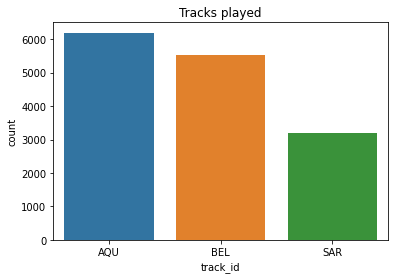

In [12]:
fig, ax = plt.subplots()
sns.countplot(data = horse_data, ax=ax, x='track_id').set(title = 'Tracks played')

AQU was the track used the most

In [13]:
horse_data['race_date'] = pd.to_datetime(horse_data['race_date'])
horse_data.head()

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish
0,AQU,2019-01-01,1,1,123,Dylan Davis,1.30,2
1,AQU,2019-01-01,1,2,120,Junior Alvarado,2.95,3
2,AQU,2019-01-01,1,3,118,Jose Lezcano,1.80,4
3,AQU,2019-01-01,1,4,123,Jomar Garcia,12.80,5
4,AQU,2019-01-01,1,5,118,Manuel Franco,11.50,1


Text(0.5, 1.0, 'Tracks throughout year')

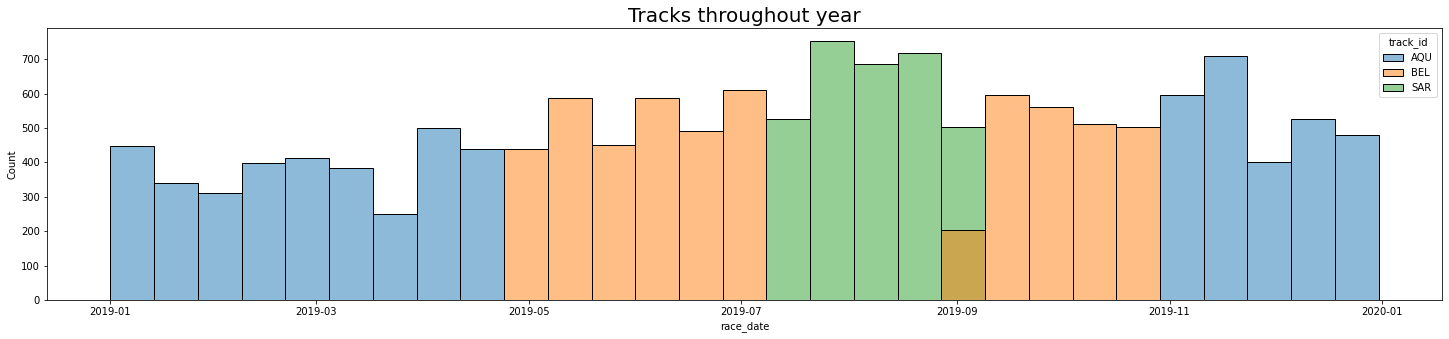

In [14]:
fig, ax = plt.subplots(figsize=(25,5))

sns.histplot(data=horse_data,hue="track_id", ax=ax,x="race_date")
ax.set_title("Tracks throughout year", fontsize=20)

AQU was used from November to April (Winter), BEL was from May to July and September to November(Summer/Autumn) and SAR was used from July to September (Summer). 

<AxesSubplot:xlabel='race_number', ylabel='count'>

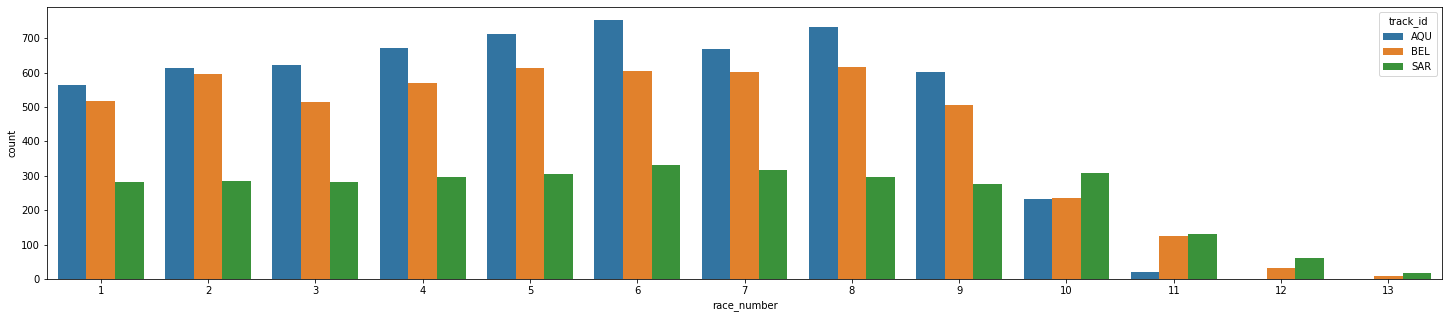

In [15]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(data = horse_data, ax=ax, x = 'race_number', hue = 'track_id')

We had up to 13 races per day, but usually it was 1-9

In [16]:
horse_data['race_number'] = horse_data['race_number'].astype('int8')

In [17]:
horse_data.program_number.value_counts()

4      1748
3      1743
5      1731
2      1715
1      1708
6      1652
7      1390
8      1066
9       761
10      535
11      333
12      201
1A      164
13       77
14       44
15       24
2B       11
16       10
3X        1
1X        1
Name: program_number, dtype: int64

In [18]:
date_num_df = horse_data.groupby(['race_date'])['race_number'].max().to_frame(name = 'number of races').reset_index()
date_num_df

,race_date,number of races
0,2019-01-01,9
1,2019-01-04,8
2,2019-01-05,9
3,2019-01-06,8
4,2019-01-10,5
...,...,...
212,2019-12-22,10
213,2019-12-28,9
214,2019-12-29,9
215,2019-12-30,8


<AxesSubplot:xlabel='number of races', ylabel='Count'>

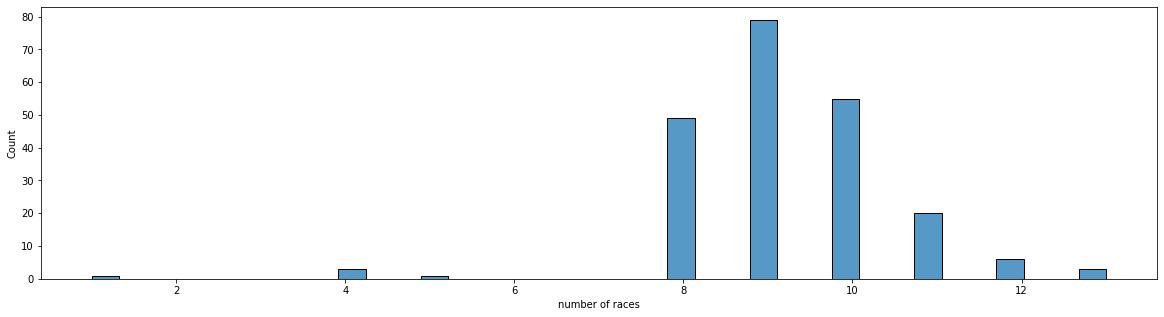

In [19]:
fig, ax = plt.subplots(figsize=(20,5))
sns.histplot(data = date_num_df, x = 'number of races')

Around 7-10 races each day. 

<AxesSubplot:xlabel='weight_carried', ylabel='Density'>

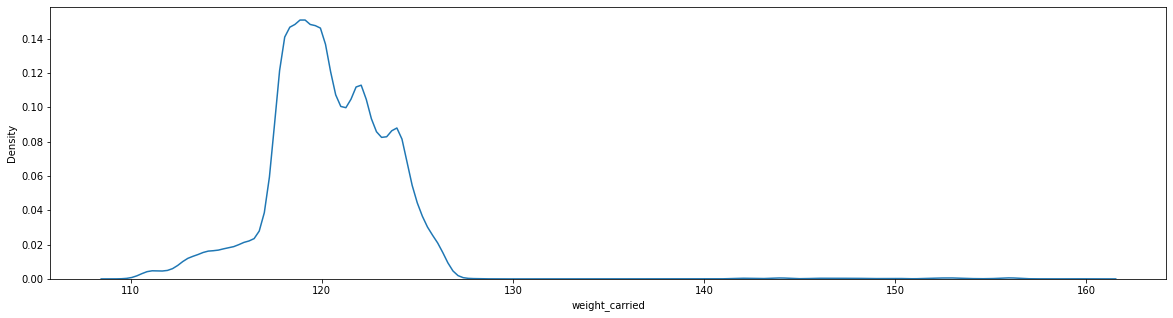

In [20]:
fig, ax = plt.subplots(figsize=(20,5))
sns.kdeplot(data = horse_data, x = 'weight_carried')

Average weight carried by horse is around 120

<AxesSubplot:xlabel='odds', ylabel='Density'>

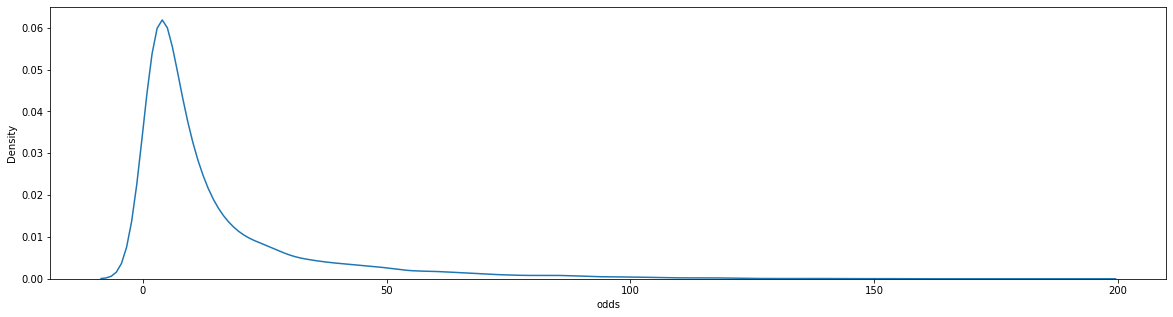

In [21]:
fig, ax = plt.subplots(figsize=(20,5))
sns.kdeplot(data = horse_data, x = 'odds')

# **RACE TABLE**

In [22]:
track_data.head()

,track_id,race_date,race_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time
0,AQU,2019-01-01,1,650,D,MY,36,AOC,80000,1220
1,AQU,2019-01-01,2,600,D,MY,48,MCL,41000,1250
2,AQU,2019-01-01,3,550,D,MY,54,MCL,35000,121
3,AQU,2019-01-01,4,900,D,MY,101,AOC,80000,150
4,AQU,2019-01-01,5,700,D,MY,60,ALW,64000,220


In [23]:
track_data['race_date'] = pd.to_datetime(track_data['race_date'])
track_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   track_id         2000 non-null   object        
 1   race_date        2000 non-null   datetime64[ns]
 2   race_number      2000 non-null   int64         
 3   distance_id      2000 non-null   int64         
 4   course_type      2000 non-null   object        
 5   track_condition  2000 non-null   object        
 6   run_up_distance  2000 non-null   int64         
 7   race_type        2000 non-null   object        
 8   purse            2000 non-null   int64         
 9   post_time        2000 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 156.4+ KB


<AxesSubplot:xlabel='course_type', ylabel='count'>

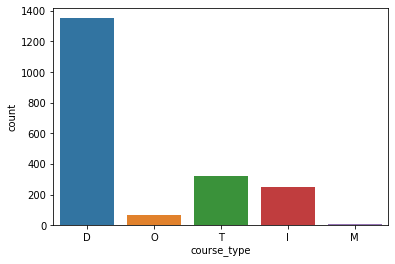

In [24]:
sns.countplot(data = track_data, x = 'course_type')

In [25]:
track_data.distance_id.value_counts()

600     545
800     402
850     249
700     242
650     196
900     138
550     131
1000     24
1100     21
500      18
950      10
1200     10
1650      5
450       2
1900      2
1600      1
1800      1
2000      1
1050      1
1400      1
Name: distance_id, dtype: int64

,distance_id,number of races
0,450,2
1,500,18
2,550,131
3,600,545
4,650,196


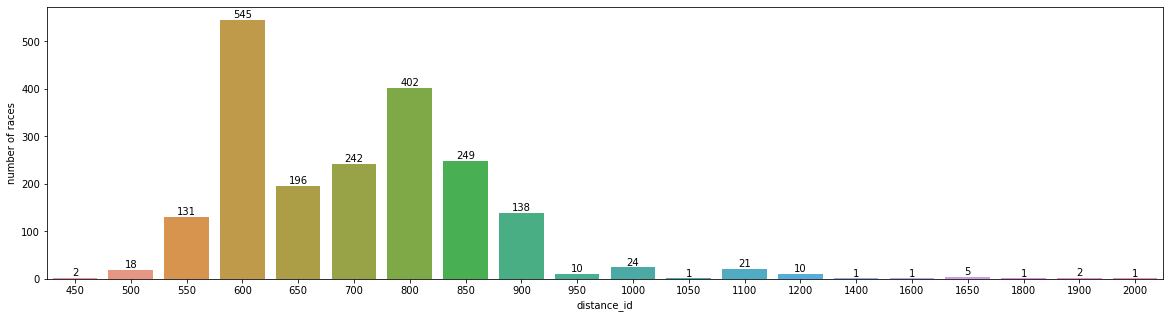

In [26]:
grp = track_data.groupby(['distance_id'])['distance_id'].count().to_frame(name = 'number of races').reset_index()
display(grp.head())
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.barplot(data = grp, x = 'distance_id', y = 'number of races')
for i in ax.containers:
    ax.bar_label(i,)

Most were 6-8 furlongs

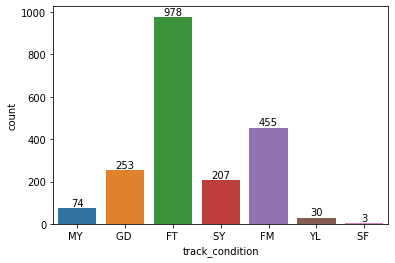

In [27]:
ax = sns.countplot(data = track_data, x = 'track_condition')
for i in ax.containers:
    ax.bar_label(i,)

Most tracks were fast

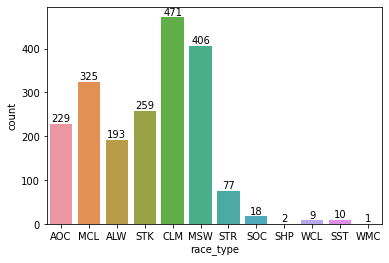

In [28]:
ax = sns.countplot(data = track_data, x = 'race_type')
for i in ax.containers:
    ax.bar_label(i,)

Most types were Claiming, Maiden Special Weight, Maiden Claiming

In [29]:
track_data.run_up_distance.describe()

count    2000.000000
mean       65.650000
std        36.111446
min         0.000000
25%        45.000000
50%        54.000000
75%        76.000000
max       280.000000
Name: run_up_distance, dtype: float64